## SVR on second iteration 
#### allows the model to be trained on the disease count the week before

some code taken from blog post:  http://blog.drivendata.org/2016/12/23/dengue-benchmark/

What I've done here is train a model (SVC) on the data to predict the total dengue cases in the test set.  I noticed the total cases predicted was low, so added in the average of the total cases per week of year throughout the entire training set to the predictions (ex. in week 52, in San Jose, the avg number of cases in the training set is 24). 

In [27]:
#standard imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import time as time

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#load dataset
df=pd.read_csv('dengue_features_train.csv')
labels = pd.read_csv('dengue_labels_train.csv')
test = pd.read_csv('test2.csv')# this is the testing data with one iteration of predictions
#fill NaNs - ffill bc it is a timeseries
df.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)
#to datetime
df['week_start_date']=pd.to_datetime(df['week_start_date'])
test['week_start_date']=pd.to_datetime(test['week_start_date'])
#extract month to new column
df['month']=df.week_start_date.dt.month
test['month']=test.week_start_date.dt.month
#merge labels
df=pd.merge(df, labels, on=['city', 'year', 'weekofyear'])
# separate san juan and iquitos
sj = df[df['city']=='sj']
iq = df[df['city']=='iq']

sj_test=test[test['city']=='sj']
iq_test=test[test['city']=='iq']

### preprocessing - add rolling averages, monthly avg, columns for previous counts of dengue

In [3]:
#define columns for preprocessing
feature_cols1=[
    'reanalysis_min_air_temp_k',
    'reanalysis_air_temp_k',
    'reanalysis_avg_temp_k',
    'reanalysis_dew_point_temp_k',
    'reanalysis_specific_humidity_g_per_kg',
    'reanalysis_sat_precip_amt_mm'
    ]

In [4]:
#create monthly avg on target var
sj['mo_avg_cases'] = sj.groupby('month')['total_cases'].transform('mean')
iq['mo_avg_cases'] = iq.groupby('month')['total_cases'].transform('mean')
sj_test['mo_avg_cases'] = sj_test.groupby('month')['total_cases'].transform('mean')
iq_test['mo_avg_cases'] = iq_test.groupby('month')['total_cases'].transform('mean')

In [5]:
#loop to make the columns with rolling averages on independent vars
#takes the avg of prior 3 weeks
#train
for col in feature_cols1:
    sj['rolling_'+col] = pd.rolling_mean(sj[col], 3)
    
for col in feature_cols1:
    iq['rolling_'+col] =  pd.rolling_mean(iq[col], 3)

#test
for col in feature_cols1:
    sj_test['rolling_'+col] = pd.rolling_mean(sj_test[col], 3)
    
for col in feature_cols1:
    iq_test['rolling_'+col] = pd.rolling_mean(iq_test[col], 3)

In [6]:
#may not be necessary but we can also do monthly min/max/range
#train
sj['max_cases'] = sj.groupby('month')['total_cases'].transform('max')
iq['max_cases'] = iq.groupby('month')['total_cases'].transform('max')

sj['min_cases'] = sj.groupby('month')['total_cases'].transform('min')
iq['min_cases'] = iq.groupby('month')['total_cases'].transform('min')

sj['range_cases']=sj['max_cases']- sj['min_cases']
iq['range_cases']=iq['max_cases']- iq['min_cases']

#test
sj_test['max_cases'] = sj_test.groupby('month')['total_cases'].transform('max')
iq_test['max_cases'] = iq_test.groupby('month')['total_cases'].transform('max')

sj_test['min_cases'] = sj_test.groupby('month')['total_cases'].transform('min')
iq_test['min_cases'] = iq_test.groupby('month')['total_cases'].transform('min')

sj_test['range_cases']=sj_test['max_cases']- sj_test['min_cases']
iq_test['range_cases']=iq_test['max_cases']- iq_test['min_cases']

In [7]:
#value previous week and two weeks previous
#train
sj['cases_prev_wk'] = sj['total_cases'].shift(1)
iq['cases_prev_wk'] = iq['total_cases'].shift(1)

sj['cases_prev_wk2'] = sj['total_cases'].shift(2)
iq['cases_prev_wk2'] = iq['total_cases'].shift(2)

#test
sj_test['cases_prev_wk'] = sj_test['total_cases'].shift(1)
iq_test['cases_prev_wk'] = iq_test['total_cases'].shift(1)

sj_test['cases_prev_wk2'] = sj_test['total_cases'].shift(2)
iq_test['cases_prev_wk2'] = iq_test['total_cases'].shift(2)

In [8]:
sj.dropna(inplace=True)
iq.dropna(inplace=True)

In [9]:
#the model didn't do well with these features
feature_cols=[
    'reanalysis_min_air_temp_k',
    'month',
    'reanalysis_air_temp_k',
    'reanalysis_avg_temp_k',
    'reanalysis_dew_point_temp_k',
    'reanalysis_specific_humidity_g_per_kg',
    'reanalysis_sat_precip_amt_mm', 
    'mo_avg_reanalysis_min_air_temp_k',
    'mo_avg_reanalysis_air_temp_k',
    'mo_avg_reanalysis_avg_temp_k',
    'mo_avg_reanalysis_dew_point_temp_k',
    'mo_avg_reanalysis_specific_humidity_g_per_kg',
    'mo_avg_reanalysis_sat_precip_amt_mm',
    'mo_avg_cases',
    'max_cases',
    'min_cases',
    'range_cases',
    'cases_prev_wk', 
    'cases_prev_wk2', 
    ]

In [10]:
#these features performed better
features2=[
    'month',
    'rolling_reanalysis_min_air_temp_k',
    'rolling_reanalysis_air_temp_k',
    'rolling_reanalysis_avg_temp_k',
    'rolling_reanalysis_dew_point_temp_k',
    'rolling_reanalysis_specific_humidity_g_per_kg',
    'rolling_reanalysis_sat_precip_amt_mm',
    'cases_prev_wk',
    'cases_prev_wk2']       

#TRAIN
X_sj= sj[features2]
Y_sj = sj['total_cases']

X_iq= iq[features2]
Y_iq = iq['total_cases']

#TEST
X_sj_t= sj_test[features2]

X_iq_t= iq_test[features2]


#need to make sure no NaNs added when creating moving avg or getting previous week values
X_sj.fillna(method='bfill', inplace=True)
X_iq.fillna(method='bfill', inplace=True)

X_sj_t.fillna(method='bfill', inplace=True)
X_iq_t.fillna(method='bfill', inplace=True)

## create model for second iteration
this iteration uses the dengue counts from the previous two weeks as a feature column
note that the dengue counts on the previous weeks for the testing set were predicted in first iteration

In [11]:
##SAN JUAN
train_size = 100
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
svr.fit(X_sj,Y_sj)
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)

SVR complexity and bandwidth selected and model fitted in 9.417 s


In [12]:
model_sj=svr.best_estimator_
model_sj

SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [13]:
##IQUITOS
train_size = 100
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
svr.fit(X_iq,Y_iq)
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)

SVR complexity and bandwidth selected and model fitted in 3.343 s


In [14]:
model_iq=svr.best_estimator_
model_iq

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [15]:
#further divide the training set to create a lineplot
sj_train_subtrain = sj.head(800)
sj_train_subtest = sj.tail(sj.shape[0] - 800)

iq_train_subtrain = iq.head(400)
iq_train_subtest = iq.tail(iq.shape[0] - 400)

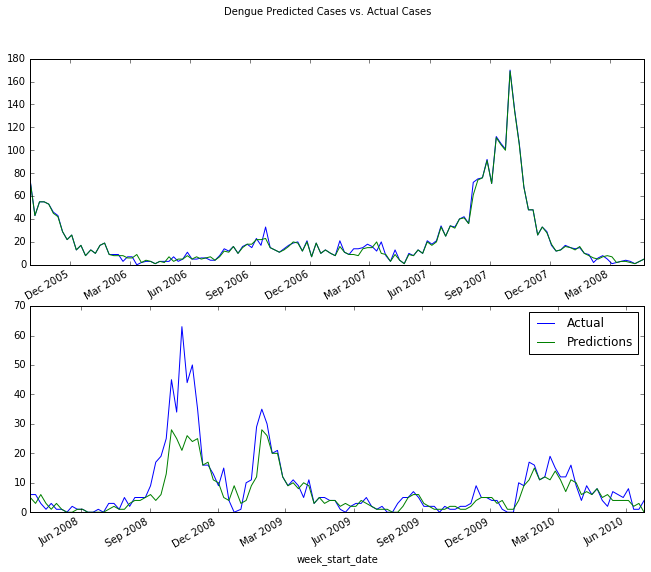

In [16]:
#create preds
preds_sj= model_sj.predict(sj_train_subtest[features2]).astype(int)
preds_iq=model_iq.predict(iq_train_subtest[features2]).astype(int)
#add to the dataframes
sj_train_subtest['fitted'] = preds_sj
iq_train_subtest['fitted'] = preds_iq
### reset axis
sj_train_subtest.index = sj_train_subtest['week_start_date']
iq_train_subtest.index = iq_train_subtest['week_start_date']
## make plot
figs, axes = plt.subplots(nrows=2, ncols=1, figsize=(11, 9))
sj_train_subtest.total_cases.plot(ax=axes[0], label="Actual")
sj_train_subtest.fitted.plot(ax=axes[0], label="Predictions")

iq_train_subtest.total_cases.plot(ax=axes[1], label="Actual")
iq_train_subtest.fitted.plot(ax=axes[1], label="Predictions")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

In [17]:
## FIT THE MODELS
model_sj.fit(X_sj,Y_sj)
model_iq.fit(X_iq,Y_iq)

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [18]:
#predict for each city using test set
sj_predictions = model_sj.predict(X_sj_t).astype(int)
iq_predictions = model_iq.predict(X_iq_t).astype(int)

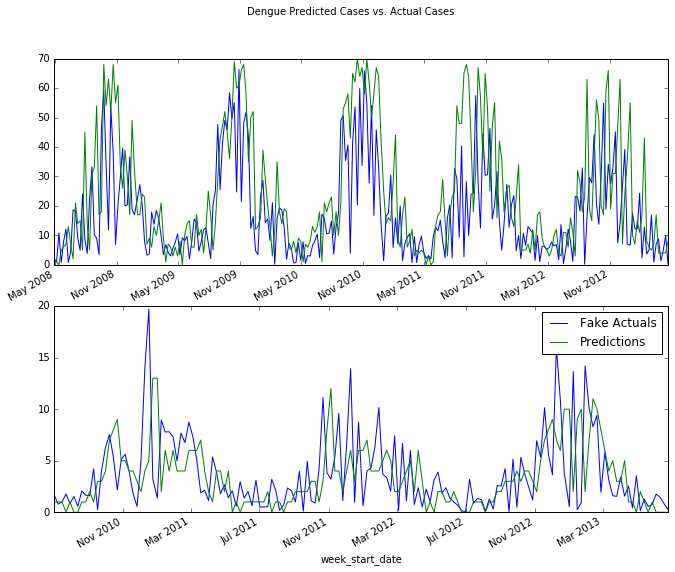

In [19]:
#VISUALIZE
sj_test['fitted'] = sj_predictions
iq_test['fitted'] = iq_predictions
### reset axis
sj_test.index = sj_test['week_start_date']
iq_test.index = iq_test['week_start_date']

figs, axes = plt.subplots(nrows=2, ncols=1, figsize=(11, 9))
sj_test.total_cases.plot(ax=axes[0], label="Fake Actuals")
sj_test.fitted.plot(ax=axes[0], label="Predictions")

iq_test.total_cases.plot(ax=axes[1], label="Fake Actuals")
iq_test.fitted.plot(ax=axes[1], label="Predictions")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

#source code:http://blog.drivendata.org/2016/12/23/dengue-benchmark/

In [20]:
#read in the driven data submission example and add the predictions
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])

submission.to_csv("submissions/svr_predictions3.csv")

### This submission had a MAE of 26.1923

## another try with negative binomial regression

Upon research this model did quite well: http://blog.drivendata.org/2016/12/23/dengue-benchmark/

The article has an awesome explaination too!

Our target variable, total_cases is a non-negative integer, which means we're looking to make some count predictions. Standard regression techniques for this type of prediction include

- Poisson regression
- Negative binomial regression

Poisson regression fits according to the assumption that the mean and variance of the population distributiona are equal. When they aren't, specifically when the variance is much larger than the mean, the negative binomial approach is better. The negative binomial regression simply lifts the assumption that the population mean and variance are equal, allowing for a larger class of possible models. 

In [21]:
#reset index so that graph has labels
sj.set_index('week_start_date', inplace=True)
iq.set_index('week_start_date', inplace=True)

#these features performed better
features2=[
    'month',
    'rolling_reanalysis_min_air_temp_k',
    'rolling_reanalysis_air_temp_k',
    'rolling_reanalysis_avg_temp_k',
    'rolling_reanalysis_dew_point_temp_k',
    'rolling_reanalysis_specific_humidity_g_per_kg',
    'rolling_reanalysis_sat_precip_amt_mm',
    'cases_prev_wk',
    'cases_prev_wk2',
    'total_cases']       

#TRAIN
X_sj= sj[features2]
Y_sj = sj['total_cases']

X_iq= iq[features2]
Y_iq = iq['total_cases']

#TEST
X_sj_t= sj_test[features2]

X_iq_t= iq_test[features2]


#need to make sure no NaNs
X_sj.fillna(method='bfill', inplace=True)
X_iq.fillna(method='bfill', inplace=True)

X_sj_t.fillna(method='bfill', inplace=True)
X_iq_t.fillna(method='bfill', inplace=True)

In [22]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import eval_measures

def get_best_model(train, test):
    # Step 1: specify the form of the model
    
  
    
    model_formula = "total_cases ~ 1 + " \
                     'month +'\
                     'rolling_reanalysis_min_air_temp_k +'\
                     'rolling_reanalysis_air_temp_k +'\
                     'rolling_reanalysis_avg_temp_k +'\
                     'rolling_reanalysis_dew_point_temp_k +'\
                     'rolling_reanalysis_specific_humidity_g_per_kg +'\
                     'rolling_reanalysis_sat_precip_amt_mm +'\
                     'cases_prev_wk +'\
                     'cases_prev_wk2'
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model

In [23]:
sj_best_model = get_best_model(X_sj,X_sj_t)
iq_best_model = get_best_model(X_iq,X_iq_t)

best alpha =  0.0001
best score =  12.3352756225
best alpha =  0.0001
best score =  2.91888868882


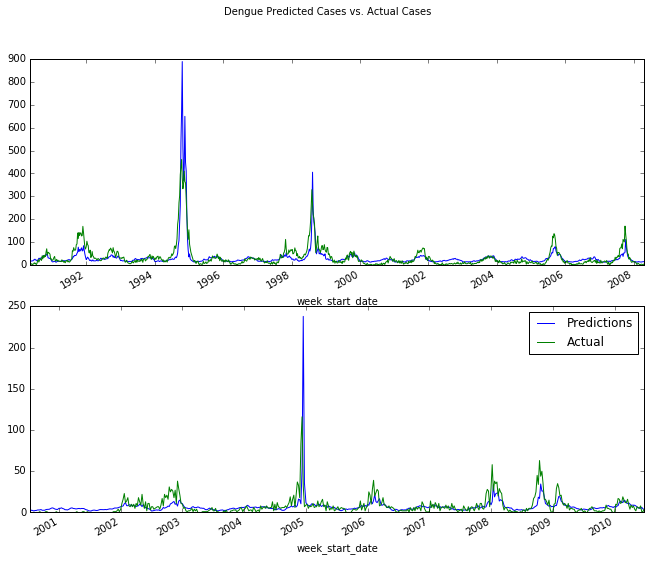

In [24]:
figs, axes = plt.subplots(nrows=2, ncols=1,figsize=(11, 9))

# plot sj
sj['fitted'] = sj_best_model.fittedvalues
sj.fitted.plot(ax=axes[0], label="Predictions")
sj.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq['fitted'] = iq_best_model.fittedvalues
iq.fitted.plot(ax=axes[1], label="Predictions")
iq.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

In [26]:
sj_predictions = sj_best_model.predict(X_sj_t).astype(int)
iq_predictions = iq_best_model.predict(X_iq_t).astype(int)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("glm_improved.csv")

### This submission had a MAE of 25.2740